**Imports**

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

import clip
import kagglehub
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from itertools import cycle
import torch.nn as nn
import torch.nn.functional as F
import os, requests
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from PIL import Image, ImageFilter
from io import BytesIO

**Creating Dataset**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()

PACS_basepath = kagglehub.dataset_download("nickfratto/pacs-dataset")

PACS_photo = datasets.ImageFolder(root=f"{PACS_basepath}/dct2_images/dct2_images/photo", transform=clip_preprocess)
PACS_painting = datasets.ImageFolder(root=f"{PACS_basepath}/dct2_images/dct2_images/art_painting", transform=clip_preprocess)
PACS_sketch = datasets.ImageFolder(root=f"{PACS_basepath}/dct2_images/dct2_images/sketch", transform=clip_preprocess)
PACS_cartoon = datasets.ImageFolder(root=f"{PACS_basepath}/dct2_images/dct2_images/cartoon", transform=clip_preprocess)

classes = PACS_photo.classes
assert PACS_painting.classes == classes and PACS_sketch.classes == classes and PACS_cartoon.classes == classes, \
       "Class order mismatch across domains!"

PACS_photo_dataloader = DataLoader(PACS_photo, batch_size=64, shuffle=False, num_workers=2)
PACS_painting_dataloader = DataLoader(PACS_painting, batch_size=64, shuffle=False, num_workers=2)
PACS_sketch_dataloader = DataLoader(PACS_sketch, batch_size=64, shuffle=False, num_workers=2)
PACS_cartoon_dataloader = DataLoader(PACS_cartoon, batch_size=64, shuffle=False, num_workers=2)

PACS_photo_prompts = [f"a photo of a {label}"    for label in classes]
PACS_painting_prompts = [f"a painting of a {label}" for label in classes]
PACS_sketch_prompts = [f"a sketch of a {label}"   for label in classes]
PACS_cartoon_prompts = [f"a cartoon of a {label}"  for label in classes]

In [ ]:
def compute_accuracy(dataloader, prompts):
  with torch.no_grad():
    text_tokens = clip.tokenize(prompts).to(device)
    text_features = clip_model.encode_text(text_tokens).to(device)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    total, correct = 0, 0
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)

      image_features = clip_model.encode_image(images).to(device)
      image_features /= image_features.norm(dim=-1, keepdim=True)

      logit_scale = clip_model.logit_scale.exp()
      similarities = (image_features @ text_features.T) * logit_scale
      predictions = similarities.argmax(dim=-1)

      correct += (predictions == labels).sum().item()
      total += labels.size(0)

  return round((correct / total) * 100, 4)

**Zero-Shot CLIP Accuracy**

In [ ]:
pacs_zero_photo_accuracy=compute_accuracy(PACS_photo_dataloader, PACS_photo_prompts)
print(f"PACS Zero-Shot Photo Accuracy: {pacs_zero_photo_accuracy:.2f}%")

pacs_zero_painting_accuracy=compute_accuracy(PACS_painting_dataloader, PACS_painting_prompts)
print(f"PACS Zero-Shot Painting Accuracy: {pacs_zero_painting_accuracy:.2f}%")

pacs_zero_sketch_accuracy=compute_accuracy(PACS_sketch_dataloader, PACS_sketch_prompts)
print(f"PACS Zero-Shot Sketch Accuracy: {pacs_zero_sketch_accuracy:.2f}%")

pacs_zero_cartoon_accuracy=compute_accuracy(PACS_cartoon_dataloader, PACS_cartoon_prompts)
print(f"PACS Zero-Shot Cartoon Accuracy: {pacs_zero_cartoon_accuracy:.2f}%")

PACS Zero-Shot Photo Accuracy: 17.13%
PACS Zero-Shot Painting Accuracy: 17.33%
PACS Zero-Shot Sketch Accuracy: 11.94%
PACS Zero-Shot Cartoon Accuracy: 16.77%


**Fine-Tuning on Domains**

In [ ]:
class LinearProbe(nn.Module):
    def __init__(self, feat_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

def extract_features(dataloader):
  all_features, all_labels = [], []
  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)

      image_features = clip_model.encode_image(images).to(device)
      image_features /= image_features.norm(dim=-1, keepdim=True)
      all_features.append(image_features.cpu().float())
      all_labels.append(labels.cpu().long())

  all_features = torch.cat(all_features, dim=0)
  all_labels = torch.cat(all_labels, dim=0)
  return all_features, all_labels

def train_linear_classifier(train_features, train_labels, val_features, val_labels, num_classes, epochs=20, lr=0.001):
  model = LinearProbe(train_features.shape[1], num_classes).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  train_features, train_labels = train_features.to(device), train_labels.to(device)
  val_features, val_labels = val_features.to(device), val_labels.to(device)

  best_acc, best_model = 0.0, None
  for epoch in range(epochs):
    model.train()
    logits = model(train_features)
    loss = criterion(logits, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      val_logits = model(val_features)
      predictions = val_logits.argmax(dim=-1)
      accuracy = (predictions == val_labels).float().mean().item()
    if accuracy > best_acc:
      best_acc = accuracy

  # model.load_state_dict(best_model)
  return best_acc

all_domains = [PACS_photo_dataloader, PACS_sketch_dataloader, PACS_cartoon_dataloader, PACS_painting_dataloader]
domain_names = ['PACS_photo', 'PACS_sketch', 'PACS_cartoon', 'PACS_painting']

results={}
for i, domain in enumerate(all_domains):
  source_domains = [dom for dom in all_domains if dom!=domain]

  all_train_features, all_train_labels = [], []
  for dom in source_domains:
      feats, labels = extract_features(dom)
      all_train_features.append(feats)
      all_train_labels.append(labels)

  train_features = torch.cat(all_train_features)
  train_labels = torch.cat(all_train_labels)

  val_features, val_labels = extract_features(domain)

  val_acc = train_linear_classifier(train_features, train_labels, val_features, val_labels, num_classes=7)
  results[domain_names[i]]=val_acc
  print(f"Target={domain_names[i]} | Linear Classifier Accuracy={val_acc*100:.2f}%")

Target=PACS_photo | Linear Classifier Accuracy=11.44%
Target=PACS_sketch | Linear Classifier Accuracy=20.23%
Target=PACS_cartoon | Linear Classifier Accuracy=22.78%
Target=PACS_painting | Linear Classifier Accuracy=14.99%


**Prompt-Learning Adaptation**

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
      super().__init__()
      self.transformer = clip_model.transformer
      self.positional_embedding = clip_model.positional_embedding
      self.ln_final = clip_model.ln_final
      self.text_projection = clip_model.text_projection
      self.dtype = clip_model.dtype

    def forward(self, prompts_embeds, eos_indices):
      N, L, D = prompts_embeds.shape

      pos_emb = self.positional_embedding[:L, :].type(self.dtype)
      x = prompts_embeds.type(self.dtype) + pos_emb.unsqueeze(0)

      x = x.permute(1, 0, 2)
      x = self.transformer(x)
      x = x.permute(1, 0, 2)
      x = self.ln_final(x).type(self.dtype)

      out = x[torch.arange(N), eos_indices] @ self.text_projection
      return out

class PromptLearner(nn.Module):
  def __init__(self, clip_model, classnames, n_ctx=8, ctx_dim=512, device='cuda'):
      super().__init__()
      self.clip_model = clip_model
      self.text_encoder = TextEncoder(clip_model)
      self.classnames = classnames
      self.device = device
      self.n_cls = len(classnames)
      self.n_ctx = n_ctx
      self.ctx_dim = ctx_dim

      self.ctx_vectors=nn.Parameter(torch.empty(self.n_cls, self.n_ctx, self.ctx_dim, dtype=torch.float32, device=device))
      nn.init.normal_(self.ctx_vectors, std=0.02)

      tokenized = torch.cat([clip.tokenize(name) for name in self.classnames], dim=0).to(self.device)
      with torch.no_grad():
        self.embeddings = clip_model.token_embedding(tokenized).detach()

      self.tokenized=tokenized

  def forward(self):
    class_prompts = []
    eos_indices_list = []
    # print('in')

    for i in range(self.n_cls):
      ctx = (self.ctx_vectors[i]).to(self.text_encoder.dtype)
      embedding = self.embeddings[i]

      valid_len = int((self.tokenized[i] != 0).sum().item())
      embedding = embedding[:valid_len]

      prompt = torch.cat([ctx, embedding], dim=0)
      class_prompts.append(prompt)

      eos_idx = self.n_ctx + (valid_len - 1)
      eos_indices_list.append(eos_idx)

    max_len=77
    padded_prompts = torch.zeros(self.n_cls, max_len, self.ctx_dim,  dtype=self.text_encoder.dtype, device=self.device)

    for i, prompt in enumerate(class_prompts):
        L = prompt.shape[0]
        padded_prompts[i, :L] = prompt

    eos_indices = torch.tensor(eos_indices_list, dtype=torch.long, device=self.device)
    text_features = self.text_encoder(padded_prompts, eos_indices)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    return text_features

In [ ]:

def domain_adaptation(src_loader, tgt_loader, classnames, clip_model, n_ctx=8, ctx_dim=512, epochs=10, lr=0.001, device="cuda"):
  clip_model.eval()
  for p in clip_model.parameters():
    p.requires_grad = False

  prompt_learner = PromptLearner(clip_model, classnames, n_ctx=n_ctx, ctx_dim=ctx_dim, device=device).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam([prompt_learner.ctx_vectors], lr=lr)

  for epoch in range(epochs):
    prompt_learner.train()
    total_loss = 0

    for (src_imgs, src_labels), (tgt_imgs, _) in zip(src_loader, tgt_loader):
      src_imgs, src_labels = src_imgs.to(device), src_labels.to(device)
      tgt_imgs = tgt_imgs.to(device)

      with torch.no_grad():
          src_feats = clip_model.encode_image(src_imgs)
          src_feats /= src_feats.norm(dim=-1, keepdim=True)

          tgt_feats = clip_model.encode_image(tgt_imgs)
          tgt_feats /= tgt_feats.norm(dim=-1, keepdim=True)

      text_feats = prompt_learner()

      src_feats = src_feats.float()
      tgt_feats = tgt_feats.float()
      text_feats = text_feats.float()

      logit_scale = torch.clamp(clip_model.logit_scale.exp(), max=50)
      src_logits = (src_feats @ text_feats.T) * logit_scale
      tgt_logits = (tgt_feats @ text_feats.T) * logit_scale

      L_src = criterion(src_logits, src_labels)

      eps = 1e-8
      p_tgt = F.softmax(tgt_logits, dim=-1)
      L_tgt = -(p_tgt * (p_tgt + eps).log()).sum(dim=1).mean()

      loss = L_src + 0.1 * L_tgt

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss={total_loss:.4f}")

  return prompt_learner

In [ ]:
def evaluate(prompt_learner, dataloader, clip_model, device="cuda"):
  prompt_learner.eval()
  correct, total = 0, 0
  with torch.no_grad():
      text_feats = prompt_learner()
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          img_feats = clip_model.encode_image(images)
          img_feats /= img_feats.norm(dim=-1, keepdim=True)
          logit_scale = clip_model.logit_scale.exp()
          logits = (img_feats @ text_feats.T) * logit_scale
          preds = logits.argmax(dim=-1)
          correct += (preds == labels).sum().item()
          total += labels.size(0)
  return correct / total * 100

prompt_learner=domain_adaptation(PACS_photo_dataloader, PACS_painting_dataloader, classes, clip_model)

classnames:  ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
Epoch 1/10, Loss=82.6664
Epoch 2/10, Loss=111.5596
Epoch 3/10, Loss=93.6247
Epoch 4/10, Loss=78.5093
Epoch 5/10, Loss=70.5820
Epoch 6/10, Loss=64.9959
Epoch 7/10, Loss=63.3547
Epoch 8/10, Loss=62.3386
Epoch 9/10, Loss=61.4294
Epoch 10/10, Loss=60.2802


In [ ]:
coop_acc=evaluate(prompt_learner, PACS_painting_dataloader, clip_model)
print(f"Accuracy: {coop_acc:.2f}%")

Accuracy: 22.17%


**Gradient Conflict and Alignment**

In [ ]:
def compute_gradient(objectives, params):
  grads_list = []
  params = list(params)

  for i, obj in enumerate(objectives):
    grads = torch.autograd.grad(obj, params, retain_graph=True, create_graph=False)
    flat_parts = []
    for g, p in zip(grads, params):
      if g is None:
        flat_parts.append(torch.zeros(p.numel(), device=device, dtype=torch.float32))
      else:
        flat_parts.append(g.contiguous().view(-1).to(device).float())
    flat = torch.cat(flat_parts, dim=0)
    grads_list.append(flat)
  return grads_list

def cosine_similarity(vec1, vec2, eps=1e-8):
    v1 = vec1.float()
    v2 = vec2.float()

    denom = (v1.norm() * v2.norm()).clamp(min=eps)
    return (v1 @ v2) / denom

def project_conflicting(grads_list, eps=1e-10):
    n = len(grads_list)
    pc_grad = [g.clone().float() for g in grads_list]
    order = list(range(n))
    random.shuffle(order)

    for i in order:
        gi = pc_grad[i]
        for j in range(n):
            if i == j:
                continue
            gj = grads_list[j]
            prod = (gi @ gj).item()
            if prod < 0:
                denom = (gj @ gj) + eps
                gi = gi - (prod / denom) * gj
        pc_grad[i] = gi

    avg_grad = torch.stack(pc_grad, dim=0).mean(dim=0)
    return pc_grad, avg_grad

In [ ]:
# cartoon & sketch
def train_baseline_domains(src1_loader, src2_loader, classnames, clip_model, n_ctx=8, ctx_dim=512, epochs=15, lr=0.001, device="cuda"):
  prompt_learner = PromptLearner(clip_model, classes, n_ctx=n_ctx, ctx_dim=ctx_dim, device=device).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam([prompt_learner.ctx_vectors], lr=lr)

  metrics = {'epochs': [], 'cos_raw': [], 'train_loss': []}

  for epoch in range(epochs):
    prompt_learner.train()
    total_loss = 0.0

    for (src1_imgs, src1_labels), (src2_imgs, src2_labels) in zip(src1_loader, cycle(src2_loader)):
      src1_imgs, src1_labels = src1_imgs.to(device), src1_labels.to(device)
      src2_imgs, src2_labels = src2_imgs.to(device), src2_labels.to(device)

      with torch.no_grad():
          src1_feats = clip_model.encode_image(src1_imgs)
          src1_feats /= src1_feats.norm(dim=-1, keepdim=True)

          src2_feats = clip_model.encode_image(src2_imgs)
          src2_feats /= src2_feats.norm(dim=-1, keepdim=True)

      text_feats = prompt_learner()

      src1_feats = src1_feats.float()
      src2_feats = src2_feats.float()
      text_feats = text_feats.float()

      logit_scale = torch.clamp(clip_model.logit_scale.exp(), max=50)
      src1_logits = (src1_feats @ text_feats.T) * logit_scale
      src2_logits = (src2_feats @ text_feats.T) * logit_scale

      L_src1 = criterion(src1_logits, src1_labels)
      L_src2 = criterion(src2_logits, src2_labels)

      loss = L_src1 + L_src2

      if (epoch + 1) % 3 == 0:
        flat_grads = compute_gradient([L_src1, L_src2], [prompt_learner.ctx_vectors])
        g1, g2 = flat_grads[0], flat_grads[1]
        cos_raw = float(cosine_similarity(g1, g2).detach().cpu().item())

      else:
        cos_raw = None

      optimizer.zero_grad()
      loss.backward()

      torch.nn.utils.clip_grad_norm_([prompt_learner.ctx_vectors], max_norm=1.0)
      optimizer.step()

      total_loss += loss.item()


    if (epoch+1)%3==0:
      metrics['epochs'].append(epoch+1)
      metrics['cos_raw'].append(cos_raw)
      metrics['train_loss'].append(total_loss)

    print(f"[Baseline] Epoch {epoch+1}/{epochs}, Loss={total_loss:.4f}")

  return prompt_learner, metrics

In [ ]:
# cartoon & sketch
def train_pcgrad_domains(src1_loader, src2_loader, classnames, clip_model, n_ctx=8, ctx_dim=512, epochs=15, lr=0.001, device="cuda"):
  prompt_learner = PromptLearner(clip_model, classes, n_ctx=n_ctx, ctx_dim=ctx_dim, device=device).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam([prompt_learner.ctx_vectors], lr=lr)

  metrics = {'epochs': [], 'cos_before': [], 'cos_after': [], 'train_loss': []}

  for epoch in range(epochs):
    prompt_learner.train()
    total_loss = 0.0

    for (src1_imgs, src1_labels), (src2_imgs, src2_labels) in zip(src1_loader, cycle(src2_loader)):
      src1_imgs, src1_labels = src1_imgs.to(device), src1_labels.to(device)
      src2_imgs, src2_labels = src2_imgs.to(device), src2_labels.to(device)

      with torch.no_grad():
          src1_feats = clip_model.encode_image(src1_imgs)
          src1_feats /= src1_feats.norm(dim=-1, keepdim=True)

          src2_feats = clip_model.encode_image(src2_imgs)
          src2_feats /= src2_feats.norm(dim=-1, keepdim=True)

      text_feats = prompt_learner()

      src1_feats = src1_feats.float()
      src2_feats = src2_feats.float()
      text_feats = text_feats.float()

      logit_scale = torch.clamp(clip_model.logit_scale.exp(), max=50)
      src1_logits = (src1_feats @ text_feats.T) * logit_scale
      src2_logits = (src2_feats @ text_feats.T) * logit_scale

      L_src1 = criterion(src1_logits, src1_labels)
      L_src2 = criterion(src2_logits, src2_labels)

      loss = L_src1 + L_src2

      if (epoch + 1) % 3 == 0:
        flat_grads = compute_gradient([L_src1, L_src2], [prompt_learner.ctx_vectors])
        g1, g2 = flat_grads[0], flat_grads[1]
        cos_before = float(cosine_similarity(g1, g2).detach().cpu().item())

        proj_list, avg_proj = project_conflicting([g1, g2])
        cos_after = float(cosine_similarity(proj_list[0], proj_list[1]).detach().cpu().item())

        optimizer.zero_grad()
        start = 0
        for p in [prompt_learner.ctx_vectors]:
            numel = p.numel()
            grad_segment = avg_proj[start:start + numel].view_as(p)
            p.grad = grad_segment.clone()
            start += numel
        torch.nn.utils.clip_grad_norm_([prompt_learner.ctx_vectors], max_norm=1.0)
        optimizer.step()

        metrics['epochs'].append(epoch+1)
        metrics['cos_before'].append(cos_before)
        metrics['cos_after'].append(cos_after)
        metrics['train_loss'].append(total_loss)

        total_loss += loss.item()
        continue

      optimizer.zero_grad()
      loss.backward()

      torch.nn.utils.clip_grad_norm_([prompt_learner.ctx_vectors], max_norm=1.0)
      optimizer.step()

      total_loss += loss.item()

    print(f"[PCGrad] Epoch {epoch+1}/{epochs}, Loss={total_loss:.4f}")

  return prompt_learner, metrics

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

# 🧩 Example: train using two source domains (e.g., PACS photo & painting)
prompt_learner_baseline, metrics_baseline = train_baseline_domains(
    PACS_cartoon_dataloader,    # domain A
    PACS_sketch_dataloader, # domain B
    classes,
    clip_model,
    n_ctx=8,
    ctx_dim=512,
    epochs=15,
    lr=0.001,
    device=device
)

prompt_learner_pcgrad, metrics_pcgrad = train_pcgrad_domains(
    PACS_cartoon_dataloader,    # domain A
    PACS_sketch_dataloader, # domain B
    classes,
    clip_model,
    n_ctx=8,
    ctx_dim=512,
    epochs=15,
    lr=0.001,
    device=device
)


classnames:  ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
[Baseline] Epoch 1/15, Loss=175.4848
[Baseline] Epoch 2/15, Loss=187.9060
[Baseline] Epoch 3/15, Loss=202.2558
[Baseline] Epoch 4/15, Loss=180.9786
[Baseline] Epoch 5/15, Loss=197.5230
[Baseline] Epoch 6/15, Loss=183.3023
[Baseline] Epoch 7/15, Loss=172.2108
[Baseline] Epoch 8/15, Loss=151.0970
[Baseline] Epoch 9/15, Loss=159.5665
[Baseline] Epoch 10/15, Loss=162.6615
[Baseline] Epoch 11/15, Loss=150.5308
[Baseline] Epoch 12/15, Loss=144.8659
[Baseline] Epoch 13/15, Loss=141.5011
[Baseline] Epoch 14/15, Loss=139.5175
[Baseline] Epoch 15/15, Loss=135.5762
classnames:  ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
[PCGrad] Epoch 1/15, Loss=159.3478
[PCGrad] Epoch 2/15, Loss=174.9076
[PCGrad] Epoch 3/15, Loss=236.9724
[PCGrad] Epoch 4/15, Loss=189.1535
[PCGrad] Epoch 5/15, Loss=214.0761
[PCGrad] Epoch 6/15, Loss=160.1807
[PCGrad] Epoch 7/15, Loss=180.1445
[PCGrad] Epoch 8/15, Loss=175.

Average Cosine Similarity:
Baseline (no alignment):       0.1761
PCGrad - After Projection:     0.3337



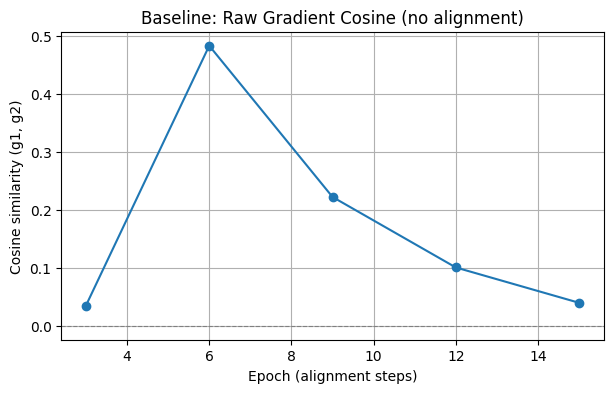

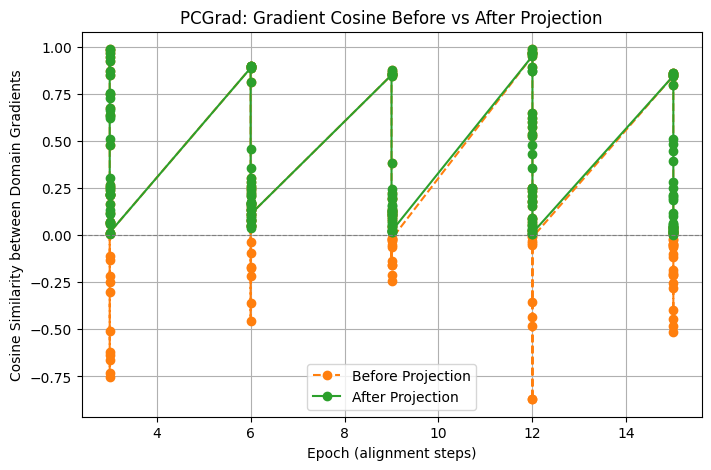


Final accuracies:
Baseline - Cartoon: 26.28%, Sketch: 25.45%
PCGrad   - Cartoon: 28.20%, Sketch: 25.60%


In [ ]:

avg_cos_baseline = sum(metrics_baseline['cos_raw']) / len(metrics_baseline['cos_raw'])
avg_cos_pcgrad_before = sum(metrics_pcgrad['cos_before']) / len(metrics_pcgrad['cos_before'])
avg_cos_pcgrad_after = sum(metrics_pcgrad['cos_after']) / len(metrics_pcgrad['cos_after'])
print("Average Cosine Similarity:")
print(f"Baseline (no alignment):       {avg_cos_baseline:.4f}")
print(f"PCGrad - After Projection:     {avg_cos_pcgrad_after:.4f}\n")

plt.figure(figsize=(7,4))
plt.plot(metrics_baseline['epochs'], metrics_baseline['cos_raw'], marker='o', linestyle='-', color='tab:blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title('Baseline: Raw Gradient Cosine (no alignment)')
plt.xlabel('Epoch (alignment steps)')
plt.ylabel('Cosine similarity (g1, g2)')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(metrics_pcgrad['epochs'], metrics_pcgrad['cos_before'],
         marker='o', linestyle='--', color='tab:orange', label='Before Projection')
plt.plot(metrics_pcgrad['epochs'], metrics_pcgrad['cos_after'],
         marker='o', linestyle='-', color='tab:green', label='After Projection')

plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title('PCGrad: Gradient Cosine Before vs After Projection')
plt.xlabel('Epoch (alignment steps)')
plt.ylabel('Cosine Similarity between Domain Gradients')
plt.legend()
plt.grid(True)
plt.show()

acc_cartoon_baseline = evaluate(prompt_learner_baseline, PACS_cartoon_dataloader, clip_model)
acc_sketch_baseline = evaluate(prompt_learner_baseline, PACS_sketch_dataloader, clip_model)
acc_cartoon_pcgrad = evaluate(prompt_learner_pcgrad, PACS_cartoon_dataloader, clip_model)
acc_sketch_pcgrad = evaluate(prompt_learner_pcgrad, PACS_sketch_dataloader, clip_model)

print("\nFinal accuracies:")
print(f"Baseline - Cartoon: {acc_cartoon_baseline:.2f}%, Sketch: {acc_sketch_baseline:.2f}%")
print(f"PCGrad   - Cartoon: {acc_cartoon_pcgrad:.2f}%, Sketch: {acc_sketch_pcgrad:.2f}%")


**Open-Set Experiment**

In [ ]:
from torch.utils.data import Subset, Dataset

all_classes = PACS_cartoon.classes
seen_classes = random.sample(all_classes, int(0.8 * len(all_classes)))
unseen_classes = [c for c in all_classes if c not in seen_classes]

print("All classes:", all_classes)
print("Seen classes:", seen_classes)
print("Unseen classes:", unseen_classes)

class_to_idx = PACS_cartoon.class_to_idx
seen_idx = [class_to_idx[c] for c in seen_classes]
unseen_idx = [class_to_idx[c] for c in unseen_classes]

remap_dict = {old: new for new, old in enumerate(seen_idx)}

class RemappedDataset(Dataset):
    def __init__(self, base_dataset, indices, remap_dict):
        self.base = base_dataset
        self.indices = indices
        self.remap_dict = remap_dict

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.base[self.indices[idx]]
        new_label = self.remap_dict[label]
        return img, new_label

seen_indices = [i for i, (_, lbl) in enumerate(PACS_cartoon.samples) if lbl in seen_idx]
unseen_indices = [i for i, (_, lbl) in enumerate(PACS_cartoon.samples) if lbl in unseen_idx]

seen_dataset = RemappedDataset(PACS_cartoon, seen_indices, remap_dict)
unseen_dataset = Subset(PACS_cartoon, unseen_indices)

seen_loader = DataLoader(seen_dataset, batch_size=64, shuffle=True, num_workers=2)
unseen_loader = DataLoader(unseen_dataset, batch_size=64, shuffle=False, num_workers=2)

All classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
Seen classes: ['giraffe', 'elephant', 'house', 'dog', 'horse']
Unseen classes: ['guitar', 'person']


In [ ]:
def prompt_tuning(train_loader, classnames, clip_model, n_ctx=8, ctx_dim=512, epochs=10, lr=0.001, device="cuda"):
    clip_model.eval()
    for p in clip_model.parameters():
        p.requires_grad = False

    prompt_learner = PromptLearner(clip_model, classnames, n_ctx=n_ctx, ctx_dim=ctx_dim, device=device).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam([prompt_learner.ctx_vectors], lr=lr)
    for epoch in range(epochs):
        prompt_learner.train()
        total_loss = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            with torch.no_grad():
                img_feats = clip_model.encode_image(imgs)
                img_feats /= img_feats.norm(dim=-1, keepdim=True)

            text_feats = prompt_learner()
            img_feats = img_feats.float()
            text_feats = text_feats.float()

            logit_scale = torch.clamp(clip_model.logit_scale.exp(), max=50)
            logits = (img_feats @ text_feats.T) * logit_scale
            loss = criterion(logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss={total_loss:.4f}")

    return prompt_learner


In [ ]:
prompt_learner=prompt_tuning(seen_loader, seen_classes, clip_model)
open_acc=evaluate(prompt_learner, seen_loader, clip_model)
print(f"Accuracy: {open_acc:.2f}%")

unseen_tokens = torch.cat([clip.tokenize(c) for c in unseen_classes]).to(device)
with torch.no_grad():
  unseen_text_feats = clip_model.encode_text(unseen_tokens)
  unseen_text_feats /= unseen_text_feats.norm(dim=-1, keepdim=True)

msp_values, entropy_values = [], []
with torch.no_grad():
  for imgs, _ in unseen_loader:
    imgs = imgs.to(device)
    img_feats = clip_model.encode_image(imgs)
    img_feats /= img_feats.norm(dim=-1, keepdim=True)
    logit_scale = torch.clamp(clip_model.logit_scale.exp(), max=50)
    logits = (img_feats @ unseen_text_feats.T) * logit_scale
    probs = F.softmax(logits, dim=-1)

    msp = probs.max(dim=-1)[0]
    entropy = (-probs * probs.log()).sum(dim=-1)

    msp_values.extend(msp.cpu().tolist())
    entropy_values.extend(entropy.cpu().tolist())

msp_mean = np.mean(msp_values)
entropy_mean = np.mean(entropy_values)

print(f"Mean MSP (confidence on unseen): {msp_mean:.4f}")
print(f"Mean entropy (uncertainty on unseen): {entropy_mean:.4f}")

classnames:  ['giraffe', 'elephant', 'house', 'dog', 'horse']
Epoch 1/10, Loss=45.8582
Epoch 2/10, Loss=41.0945
Epoch 3/10, Loss=39.3914
Epoch 4/10, Loss=37.1521
Epoch 5/10, Loss=37.1145
Epoch 6/10, Loss=36.8301
Epoch 7/10, Loss=35.7402
Epoch 8/10, Loss=35.0826
Epoch 9/10, Loss=34.4425
Epoch 10/10, Loss=34.1950
Accuracy: 50.39%
Mean MSP (confidence on unseen): 0.8614
Mean entropy (uncertainty on unseen): 0.3985


In [ ]:
def unseen_text_features(classnames):
  tokens = clip.tokenize([f"a cartoon of a {c}" for c in classnames]).to(device)
  with torch.no_grad():
    text_feats = clip_model.encode_text(tokens)
    text_feats /= text_feats.norm(dim=1, keepdim=True)
  return text_feats

seen_text_feats = prompt_learner()
zero_shot_text_feats = unseen_text_features(seen_classes).to(device).float()

seen_text_feats = seen_text_feats.to(device=device, dtype=torch.float32)
zero_shot_text_feats = zero_shot_text_feats.to(device=device, dtype=torch.float32)

def evaluate_scores(clip_model, seen_loader, unseen_loader, seen_text_feats):
  scores, labels = [], []

  for images, _ in seen_loader:
    images = images.to(device)
    with torch.no_grad():
        img_feats = clip_model.encode_image(images).float()
        img_feats /= img_feats.norm(dim=-1, keepdim=True).to(device=device, dtype=torch.float32)
        logit_scale = torch.clamp(clip_model.logit_scale.exp(), max=50)
        logits = (img_feats @ seen_text_feats.T) * logit_scale
        probs = torch.softmax(logits.float(), dim=-1)
        msp = probs.max(dim=-1).values.cpu().numpy()
    scores.extend(msp.tolist())
    labels.extend([1] * len(images))

  for images, _ in unseen_loader:
    images = images.to(device)
    with torch.no_grad():
        img_feats = clip_model.encode_image(images).float()
        img_feats /= img_feats.norm(dim=-1, keepdim=True).to(device=device, dtype=torch.float32)
        logit_scale = torch.clamp(clip_model.logit_scale.exp(), max=50)
        logits = (img_feats @ seen_text_feats.T) * logit_scale
        probs = torch.softmax(logits.float(), dim=-1)
        msp = probs.max(dim=-1).values.cpu().numpy()
    scores.extend(msp.tolist())
    labels.extend([0] * len(images))

  return np.array(scores), np.array(labels)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

scores_tuned, labels_tuned = evaluate_scores(clip_model, seen_loader, unseen_loader, seen_text_feats)
scores_zero, labels_zero = evaluate_scores(clip_model, seen_loader, unseen_loader, zero_shot_text_feats)

def compute_metrics(scores, labels, label="Model"):
    auroc = roc_auc_score(labels, scores)
    fpr, tpr, thr = roc_curve(labels, scores)
    target_tpr = 0.95
    idx = np.argmax(tpr >= target_tpr)
    fpr95 = fpr[idx] if idx < len(fpr) else 1.0
    print(f"[{label}] AUROC: {auroc:.4f} | FPR@95TPR: {fpr95:.4f}")
    return auroc, fpr95

print("\n Open-Set Evaluation Results ")
compute_metrics(scores_zero, labels_zero, "Zero-Shot CLIP")
compute_metrics(scores_tuned, labels_tuned, "Prompt-Tuned CLIP")


 Open-Set Evaluation Results 
[Zero-Shot CLIP] AUROC: 0.5243 | FPR@95TPR: 0.9500
[Prompt-Tuned CLIP] AUROC: 0.5669 | FPR@95TPR: 0.9500


(0.5668586269196025, 0.95)

In [ ]:
prompt_source = prompt_tuning(PACS_sketch_dataloader, classes, clip_model)
prompt_target = prompt_tuning(PACS_cartoon_dataloader, classes, clip_model)

with torch.no_grad():
  src_prompts = prompt_source.ctx_vectors.detach().cpu()
  tgt_prompts = prompt_target.ctx_vectors.detach().cpu()

  src_flat = src_prompts.view(-1)
  tgt_flat = tgt_prompts.view(-1)

  cos_sim = F.cosine_similarity(src_flat.unsqueeze(0), tgt_flat.unsqueeze(0)).item()
  print(f"Cosine similarity between source and target prompts: {cos_sim:.4f}")

for i, cname in enumerate(classes):
  sim = F.cosine_similarity(src_prompts[i].view(-1), tgt_prompts[i].view(-1), dim=0).item()
  print(f"Class '{cname}': cosine similarity = {sim:.4f}")

classnames:  ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
Epoch 1/10, Loss=135.0726
Epoch 2/10, Loss=155.8802
Epoch 3/10, Loss=173.7966
Epoch 4/10, Loss=165.4206
Epoch 5/10, Loss=134.6110
Epoch 6/10, Loss=128.2993
Epoch 7/10, Loss=126.3179
Epoch 8/10, Loss=123.5961
Epoch 9/10, Loss=122.1361
Epoch 10/10, Loss=121.1685
classnames:  ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
Epoch 1/10, Loss=111.9063
Epoch 2/10, Loss=121.4544
Epoch 3/10, Loss=135.3038
Epoch 4/10, Loss=108.1660
Epoch 5/10, Loss=89.0007
Epoch 6/10, Loss=84.9806
Epoch 7/10, Loss=82.3157
Epoch 8/10, Loss=80.8931
Epoch 9/10, Loss=79.5463
Epoch 10/10, Loss=79.1806
Cosine similarity between source and target prompts: 0.0132
Class 'dog': cosine similarity = 0.0295
Class 'elephant': cosine similarity = 0.0147
Class 'giraffe': cosine similarity = -0.0063
Class 'guitar': cosine similarity = 0.0221
Class 'horse': cosine similarity = 0.0039
Class 'house': cosine similarity = -0.0175
Cl